# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


## Import libraries, define data loader and neural network

In [0]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import matplotlib.pyplot as plt
import sys # define path for data loader
import time
from tqdm import tqdm_notebook as tqdm
import os

import torch.nn as nn
import torch.nn.functional as F

# if you're running in google colab
# 1. Comment this
# %matplotlib inline
## reload modules before executing each line
# %reload_ext autoreload 
# %autoreload 2
# 2. Uncomment this
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = root_dir + 'YDS/'
data_dir = root_dir + 'data/'
models_dir = root_dir + 'models/'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import warnings
warnings.filterwarnings('ignore')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"../data/TinyImagenet" # PATH TO THE DATASET

# If true, save model parameters to GDrive
COLAB = True

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 64

# Number of classes in the dataset
NUM_CLASSES = 200

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.4914, 0.4822, 0.4465] # ImageNet: [0.485, 0.456, 0.406]; my: [0.4801826,  0.44812322, 0.39764285] from YDS:
image_std  = [0.2023, 0.1994, 0.2010] # ImageNet: [0.229, 0.224, 0.225])

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 512

In [0]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py -O tiny_img.py
DATA_PATH = '.'
# 3. comment this
# sys.path.insert(0, DATA_PATH)

from tiny_img import download_tinyImg200
# download_tinyImg200(DATA_PATH)
# Use 100k examples for training and validation (and testing). There is also 10k images in tiny-imagenet-200/test folder.
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset, val_dataset = torch.utils.data.random_split(val_dataset, [10000, 10000])
# test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/test', transform=transforms.ToTensor())

--2019-05-03 08:02:08--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3378 (3.3K) [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]   3.30K  --.-KB/s    in 0s      

2019-05-03 08:02:08 (78.6 MB/s) - ‘tiny_img.py’ saved [3378/3378]



In [0]:
tinyimagenet_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(image_mean), torch.FloatTensor(image_std))
]
)

tinyimagenet_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(image_mean), torch.FloatTensor(image_std))
]
)

# Reload datasets
dataset_norm = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=tinyimagenet_transform_norm)
train_dataset_norm, val_dataset_norm = torch.utils.data.random_split(dataset_norm, [90000, 10000])
test_dataset_norm = torchvision.datasets.ImageFolder('tiny-imagenet-200/test', transform=tinyimagenet_test_transform_norm)

In [0]:
norm = True
train_batch_gen = torch.utils.data.DataLoader(train_dataset if not norm else train_dataset_norm , 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              num_workers=NUM_WORKERS)
val_batch_gen = torch.utils.data.DataLoader(val_dataset if not norm else val_dataset_norm , 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True, 
                                            num_workers=NUM_WORKERS)

test_batch_gen = torch.utils.data.DataLoader(test_dataset if not norm else test_dataset_norm, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle=True, 
                                             num_workers=NUM_WORKERS)


Count mean and std for each channel. Should be done once for every new dataset

In [0]:
# Assume t.shape == (channels, h, w)
# image_means = torch.stack([torch.mean(t, (1,2)) for t, c in train_dataset])
# image_means = torch.mean(image_means, 0)

# image_means = np.mean([item.numpy() for item, _ in train_dataset], axis=(0,2,3)) # [0.4801826  0.44812322 0.39764285]

## Crashes with "Not enough memory" error 
# image_std = torch.stack([t.var(1).var(1) for t, c in train_dataset])
# image_std = torch.var(image_std,0)

# image_std = np.std([item.numpy() for item, _ in train_dataset], axis=(0,2,3))


In [0]:
def plot_from_batch_generator(batch_gen, grid_size=3, normalize=False):
    """
    Plots :grid_size: images from :batch_gen:
    If :normalize: = True uses precomputed mean and std
    """
    
    # Get a batch of data
    data_batch, label_batch = next(iter(batch_gen))
    # Make a grid from batch
    grid = torchvision.utils.make_grid(data_batch[: grid_size * grid_size], nrow=grid_size)
    
    # convert to numpy.ndarray and change axes order [C, H, W] -> [H, W, C]
    grid_ndarray = np.transpose(grid.numpy(), [1, 2, 0])
     
    # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()     
    if normalize:
      src = np.clip(image_std * grid_ndarray + image_mean, 0, 1)
    else:
      src = grid_ndarray
    
    plt.imshow(src)
    
#     class_names = batch_gen.dataset.classes
#     title=['Label = %d (%s)' % (x, class_names[x]) for x in label_batch]

#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated'



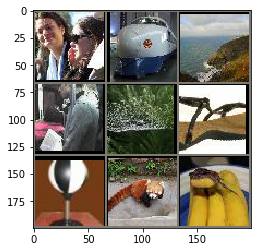

In [0]:
plot_from_batch_generator(train_batch_gen, normalize=norm)

### Build a network

In [0]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
def compute_loss(X_batch, y_batch):
    """ Docstring"""
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

#### Simple Dense and SNN net's

In [0]:
class BaselineDenseNet(nn.Module):
    
    def __init__(self):
        super(BaselineDenseNet, self).__init__()
        
        # One way to define network - set a bunch of layers using nn.Sequential
        self.model = nn.Sequential()

        # reshape from "images" to flat vectors
        self.model.add_module('flatten', Flatten())

        # dense "head"
        self.model.add_module('linear1', nn.Linear(3 * 64 * 64, 1024))
        self.model.add_module('linear2', nn.Linear(1024, 512))
        self.model.add_module('dropout0', nn.Dropout(0.05)) 
        self.model.add_module('linear3', nn.Linear(512, 256))
        self.model.add_module('dropout1', nn.Dropout(0.05))
        self.model.add_module('linear4', nn.Linear(256, 64))
        self.model.add_module('dropout2', nn.Dropout(0.05))
        self.model.add_module('dense1_relu', nn.ReLU())
        self.model.add_module('dense2_logits', nn.Linear(64, 200)) # logits for 200 classes

        
    def forward(self, x):
        x = self.model(x)
        return x

In [0]:
# base_dence = BaselineDenseNet().to(device)
# summary(base_dence, (3, SIZE_H, SIZE_W))

In [0]:
class LeNet(nn.Module):
    """
    The simplest CNN arcitecture from Yan LeCun (except ReLU and BatchNorm)
    """
    
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Another way is to define all modules inside nn.Sequential
        # _ x 3 x 64 x 64
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            # _ x 32 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 32 x 32
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            # _ x 64 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 16 x 16
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            # _ x 128 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            # _ x 128 x 8 x 8            
        )

        self.fc = nn.Sequential(
            # this converts our 3D feature maps to 1D feature vectors
            Flatten(),
            # _ x 128 * 8 * 8 
            nn.Linear(128 * 8 * 8, EMBEDDING_SIZE),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            # _ x EMBEDDING_SIZE
            nn.ReLU(),
            nn.Dropout(0.5),       
        )

        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            # _ x NUM_CLASSES
            nn.Sigmoid()
        )

        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

In [0]:
# lenet = LeNet().to(device)
# summary(lenet, (3, SIZE_H, SIZE_W))

In [0]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Third way - describe layers and call them explicitly during `forward` pass
       
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        
        # "flatten" the data
        self.flat = Flatten()
        
        # last fully-connected layer, used to create embedding vectors
        self.fc1 = nn.Linear(128, EMBEDDING_SIZE)
  
        # logits for NUM_CLASSES=2 classes
        self.fc_logits = nn.Linear(EMBEDDING_SIZE, NUM_CLASSES)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # global average pooling
        # 20 - oставшийся размер картинки, должно быть 128 каналов
        x = F.avg_pool2d(F.relu(self.conv3(x)), 20)
        x = self.flat(x)

        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc_logits(x))
        return x


In [0]:
# simple_cnn = SimpleCNN().to(device)
# summary(simple_cnn, (3, SIZE_H, SIZE_W))

#### Better CNN's (Custom + ResNet)

In [0]:
class GoodCNN(nn.Module):

    def __init__(self):
        super(GoodCNN, self).__init__()
        
        # _ x 3 x 64 x 64
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            # _ x 32 x 64 x 64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 32 x 32
            
            nn.Conv2d(32, 64, 3, padding=1),
            # _ x 64 x 32 x 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 16 x 16
            
            nn.Conv2d(64, 128, 3, padding=1),
            # _ x 128 x 16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(16)
            # _ x 128 x 1 x 1     
        )
        
        self.fc = nn.Sequential(
            Flatten(),
            # _ x 128
            nn.Linear(128, EMBEDDING_SIZE),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            nn.ReLU()
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.Sigmoid() # nn.LogSoftMax?
        )
        

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x


In [0]:
# goodcnn = GoodCNN().to(device)
# summary(goodcnn, (3, SIZE_H, SIZE_W))

In [0]:
# Torch implementation of ResNet https://arxiv.org/abs/1512.03385
DOWNSAMPLE_COEF =2 
def x_downsample(in_channels):
     return nn.Conv2d(in_channels, 
                      in_channels * DOWNSAMPLE_COEF,
                      kernel_size=1,
                      stride=DOWNSAMPLE_COEF,
                      bias=False)

class ResidualBlock(nn.Module):
    """
    Base building block for ResNet convolutions.
    :downsample: increase number of in_channels by DOWNSAMPLE_COEF
    :skip_connection: add block input to block output. False == no `residual` part
    Input size [B x in_cnannels x H x W]
    Output size if downsample: 
                    [B x in_channels * DOWNSAMPLE_COEF x H // 2 x W // 2]
                else:
                    [B x in_channels x H x W]
    
    """
    DOWNSAMPLE_COEF = 2
    
    def __init__(self, in_channels, downsample=False, skip_connection=True):
        super(ResidualBlock, self).__init__()
        
        self.skip_connection = skip_connection
        self.downsample = downsample
        coef = DOWNSAMPLE_COEF if downsample else 1
        out_channels = in_channels * coef
        
        if downsample and skip_connection:
            #downsample shortcut branch if needed
            self.short_conv = x_downsample(in_channels) 
 
        self.block = nn.Sequential(
            # stride=2 if downsample else 1
            #conv3x3
            nn.Conv2d(in_channels, out_channels, 
                      stride=coef,
                      kernel_size=3, 
                      padding=1, 
                      bias=False),            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 
                      kernel_size=3, 
                      padding=1, 
                      bias=False),   
            nn.BatchNorm2d(out_channels)
        )
            
    def forward(self, x):
        ###forward блок с учетом флагов downsample и skip_connection
        skip = x
        out = self.block(x)
        
        if self.skip_connection:
            if self.downsample:
                skip = self.short_conv(skip)
            out = torch.add(out, skip)
        out = nn.ReLU()(out)
        
        return out

# doesn't work =(
class ResidualBottleneckBlock(nn.Module):
    """
    Decrease in_channels by BOTTLENECK_COEF, then convolve and
    increase again.
    :downsample: increase number of in_channels by DOWNSAMPLE_COEF
    :skip_connection: add block input to block output. False == no `residual` part
    Input size [B x in_cnannels x H x W]
    Output size if downsample: 
                    [B x in_channels * DOWNSAMPLE_COEF x H // 2 x W // 2]
                else:
                    [B x in_channels x H x W]
    """
    
    DOWNSAMPLE_COEF = 2
    BOTTLENECK_COEF = 4
     
    def __init__(self, in_channels, downsample=False, skip_connection=True):
        super(ResidualBottleneckBlock, self).__init__()
        
        self.skip_connection = skip_connection
        self.downsample = downsample
        coef = DOWNSAMPLE_COEF if downsample else 1 
        bneck_channels = in_channels * coef // self.BOTTLENECK_COEF
        out_channels = in_channels * coef
        
        ### 
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels,
                      bneck_channels, 
                      kernel_size=1, 
                      padding=1, # (0,0) 
                      bias=False),
            
            nn.BatchNorm2d(bneck_channels),
            nn.ReLU(),
            
            nn.Conv2d(bneck_channels, bneck_channels, 
                      stride=coef,
                      kernel_size=3, 
                      padding=1, 
                      bias=False), 
            nn.BatchNorm2d(bneck_channels),
            nn.ReLU(),
            
            nn.Conv2d(bneck_channels, 
                      out_channels,
                      kernel_size=1, 
                      bias=False),
            nn.BatchNorm2d(out_channels)
        )

        if downsample and skip_connection:
            #downsample shortcut branch if needed
            self.short_conv = x_downsample(in_channels) 

            
    def forward(self, x):
        ###forward блок с учетом флагов downsample и skip_connection
        skip = x
        
        out = self.bottleneck(x)

        if self.skip_connection:
            if self.downsample:
                skip = self.short_conv(skip)
            out = torch.add(out, skip)
        out = nn.ReLU()(out)

        return out
      
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        
        # _ x 3 x 64 x 64
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            # _ x 64 x 64 x 64
            ResidualBlock(64),
            ResidualBlock(64, downsample=True),
            # _ x 128 x 32 x 32
            
            ResidualBlock(128),
            ResidualBlock(128, downsample=True),
            # _ x 256 x 16 x 16
            
            ResidualBlock(256),
            ResidualBlock(256, downsample=True),
            # _ x 512 x 8 x 8            
            
            ResidualBlock(512),
            ResidualBlock(512,),
            # _ x 512 x 8 x 8
            
            nn.AvgPool2d(8),
            # _ x 512 x 1 x 1

        )
        
        self.fc = nn.Sequential(
            Flatten(),
            # _ x 512
            nn.Linear(512, EMBEDDING_SIZE * 2),
            nn.BatchNorm1d(EMBEDDING_SIZE * 2),
            nn.ReLU()
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE * 2, NUM_CLASSES),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
       
        return x
     
    def reset_parameters(self):
        
        for module in self.model:
            try:
                module.reset_parameters()
            except AttributeError:
                pass
            
        for module in self.fc:
            try:
                module.reset_parameters()
            except AttributeError:
                pass
                
        for module in self.pred:
            try:
                module.reset_parameters()
            except AttributeError:  
                pass

In [0]:
# resnet = ResNet().to(device)
# summary(resnet, (3, SIZE_H, SIZE_W))


## Training

In [0]:
def train_model(model, train_batch_generator, val_batch_generator,
                opt=None, ckpt_name=None, n_epochs=EPOCH_NUM,
                annealing=False, verbose=True):
    
    # Logging per-epoch statistics
    logs = {'epoch': [], 'train_loss': [], 'val_loss': [],
        'val_accuracy': [],'top_val_accuracy' : 0, 'lr': []}
     
    best_model = None
    iteration = 0
    top_val_accuracy = 0
    
    model = model.to(device)
#     criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss(reduction='mean')
    
    if opt:
        optimizer=opt
    else:
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=0.001, 
                                    weight_decay=0, 
                                    momentum=0.9)
    
    for epoch in range(n_epochs):
        start_time = time.time()
        # Stores per-iteration statistics for current epoch
        train_loss = []
        val_loss = []
        val_accuracy = []
        
        if epoch == 20 and annealing:
            optimizer.param_groups[0]['lr'] *= .1  
        elif epoch == 45 and annealing:
            optimizer.param_groups[0]['lr'] *= .1
        
        # TRAIN
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()    
            
            optimizer.step()
            # zero the parameter gradients
            optimizer.zero_grad()

            train_loss.append(loss.cpu().data.numpy())
#             if annealing: scheduler.step(epoch)
        
        # TEST / VALIDATE
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_batch_generator:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.cpu().data.numpy())
            
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
            
        clear_output(wait=True)
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        
        train_loss_value = np.mean(train_loss)
        val_accuracy_value = np.mean(val_accuracy) * 100
        
        #Crutch to add parameter to the model
        model.register_buffer('val_accuracy', torch.Tensor([val_accuracy_value]))
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            # print('top val accuracy: %.3f' % top_val_accuracy)
            # save checkpoint of the best model to disk
            if not COLAB:
                with open(ckpt_name, 'wb') as f: torch.save(model, f)
            else:
                with open(models_dir + ckpt_name, 'wb') as f: torch.save(model, f)
        
        logs['epoch'].append(epoch)
        logs['train_loss'].append(np.mean(train_loss))
        logs['val_loss'].append(np.mean(val_loss))
        logs['val_accuracy'].append(np.mean(val_accuracy))
        logs['lr'].append(optimizer.param_groups[0]['lr'])
        
        print("  training loss: \t{:.6f}".format(logs['train_loss'][-1]))
        print("  validation accuracy: \t\t\t{:.2f} %".format(logs['val_accuracy'][-1]))
        custom_objects = (logs, )
    
    # Load best model found during trainig
    if ckpt_name is not None:
      if not COLAB:
        with open(ckpt_name, 'rb') as f: best_model = torch.load(f)
      else:
        with open(models_dir + ckpt_name, 'rb') as f: best_model = torch.load(f)

    return best_model, opt, custom_objects
    
def test_model(model, test_batch_generator, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_batch_generator:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print("  {} accuracy:\t\t{:.2f} %".format(subset, test_accuracy * 100))
    if test_accuracy * 100 > 90:
        print("Amazing!")
    elif test_accuracy * 100 > 70:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

In [0]:
def lr_finder(model, train_batch_generator, opt, lr_start=1e-8, lr_end=1e3, beta=0.99, plot=True):
    """
    Search for optimal learning rate and plot it's landscape
    Used: docs.fast.ai/callbacks.one_cycle.html and
          sgugger.github.io/the-1cycle-policy.html
    """
    loss_history, lr_history= [], []
    i, avg_loss, best_loss = 0, 0., float('inf')
    
    criterion = nn.CrossEntropyLoss()
    
    # Number of iterations for one epoch
    N = len(train_batch_gen)
    # Evenly distribute lr samples on log scale
    q = (lr_end / lr_start) ** (1/N)
    lr = lr_start
    
    optimizer = opt
    optimizer.param_groups[0]['lr'] = lr
    
    for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Searching'):
        i += 1
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute loss, calc grads, perform optimizer step and zero the grads
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        #Smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**i)
        
        #Stop if the loss is exploding
        if i > 1 and smoothed_loss > 4 * best_loss:
            return loss_history, lr_history 
          
        #Record the best loss
        if smoothed_loss < best_loss or i==1:
            best_loss = smoothed_loss
            best_lr = lr
            
        #Store the values
        loss_history.append(smoothed_loss)
        lr_history.append(np.log10(lr))
        
        #Do optimizer step
        loss.backward()    

        optimizer.step()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #Update the lr for the next step
        lr *= q
        optimizer.param_groups[0]['lr'] = lr
        
    if plot:
        fig, ax = plt.subplots(1,1)
        ax.plot(lr_history,loss_history)
        ax.set_xlabel('LR')
        ax.set_ylabel('Loss')
       
    return loss_history, lr_history, best_lr

No handles with labels found to put in legend.


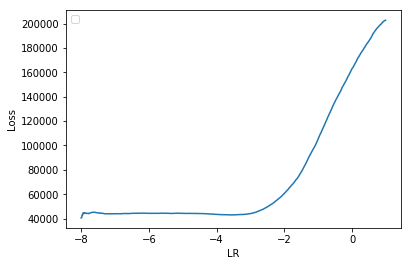

In [0]:
# _, _ = lr_finder(model, train_batch_gen, opt)


In [0]:
baseline = BaselineDenseNet()
# train_network(baseline, torch.device(DEVICE), a_epochs=10)

# opt = torch.optim.SGD(baseline.parameters(), lr=1e-2)
opt = torch.optim.Adam(baseline.parameters(), lr=1e-3, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)

In [0]:
# bm_baseline, _, _ = train_model(baseline, train_batch_gen, val_batch_gen, opt, ckpt_name='baseline', n_epochs=10

# print('parameters',baseline.state_dict)
# test = 2
# baseline.register_buffer('val_accuracy', torch.Tensor([test]))
baseline.state_dict()['val_accuracy'][0].item()

2.0

In [0]:
le_net = LeNet()
opt = torch.optim.Adam(le_net.parameters(), 
                       lr=3e-4, 
                       betas=(0.9, 0.99), 
                       eps=1e-08, 
                       weight_decay=0)

In [0]:
bm_lenet, _, custom_lenet = train_model(le_net, train_batch_gen, val_batch_gen, opt, ckpt_name='le_net', n_epochs=10)

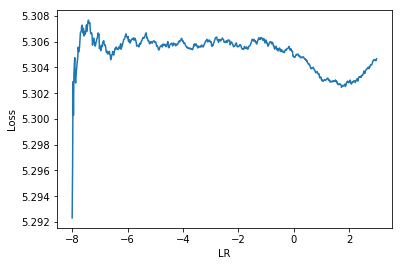

In [0]:
l, lr = lr_finder(le_net, train_batch_gen, opt)

In [0]:
opt.param_groups[0]['lr']

0.0003

In [0]:
goodcnn = GoodCNN()
opt = torch.optim.Adam(goodcnn.parameters(), lr=4e-4, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)

In [0]:
# bm_goodcnn, _, custom_goodcnn = train_model(goodcnn, train_batch_gen, val_batch_gen, opt, ckpt_name='goodcnn', n_epochs=10)

In [0]:
model = ResNet()
model_name = 'res_net'
# Try to load previosly trained model first
try:
    with open(root_dir + 'models/'+ model_name, 'rb') as f: model = torch.load(f)
  #   summary(res_net, (3, SIZE_H, SIZE_W))
    try:
        acc = model.state_dict()['val_accuracy'][0].item()
        print("Model validation accuracy = {:.2f}%".format(acc))
    except KeyError:
        pass
    print("Loaded succesfully!")
except (FileNotFoundError, ) as e:
   print("Pre-trained model not found. Err msg: '{}' ".format(e.args[-1]))
  
  
opt = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)

Model validation accuracy = 43.99%
Loaded succesfully!


In [0]:
bm_resnet, _, custom_resnet = train_model(model, train_batch_gen, val_batch_gen, opt, ckpt_name=model_name, n_epochs=30)

Epoch 1 of 30 took 472.579s
  training loss (in-iteration): 	4.445209
  validation accuracy: 			43.99 %


KeyboardInterrupt: ignored

In [0]:
test_model(model, test_batch_gen)

Results:
  test accuracy:		0.50 %
We need more magic! Follow instructons below


0.005043512658227848

### Final test

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in val_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [0]:
test_accuracy = .... # YOUR CODE

In [0]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]